In [640]:
# importing required libraries
import numpy as np
import pandas as pd
import sklearn
import scipy as sp
import matplotlib.pyplot as plt

In [641]:
# reading the dataset and ensuring it is Integer format
dataset = pd.read_csv('Iron_dealers_data.csv')
dataset['Value'] = dataset['Value'].astype(int)
dataset

,Seller ID,Buyer ID,Value
0,1309,1011,1225513
1,1309,1011,1179061
2,1309,1011,1119561
3,1309,1011,1200934
4,1309,1011,1658957
...,...,...,...
130530,1344,1390,212390
130531,1914,1390,28739
130532,1914,1390,46861
130533,1914,1390,10585


In [642]:
# will store pairs of seller and buyer
sell_buy = {}

# for each seller buyer, stores the transaction values
transactions = {}

for row in dataset.iterrows():
    
    row = row[1]

    # if seller has not been seen so far, add it to the dictionary
    if row['Seller ID'] not in sell_buy:
        sell_buy[row['Seller ID']] = []

    sell_buy[row['Seller ID']].append(row['Buyer ID'])

    # if not already present, add the pair to the dictionary
    if (row['Seller ID'], row['Buyer ID']) not in transactions:
        transactions[(row['Seller ID'], row['Buyer ID'])] = []
    
    transactions[(row['Seller ID'], row['Buyer ID'])].append(row['Value'])

# set helps to extract unique values
for key in sell_buy.keys():
    sell_buy[key] = list(set(sell_buy[key]))

In [643]:
# replacing multiple edges with the sum of values of all edges

for key in transactions.keys():
    transactions[key] = sum(transactions[key])

In [644]:
# obtaining the two cycles in the graph
two_cycles = []

for key in sell_buy.keys():
    js = sell_buy[key]
    for j in js:
        if j in sell_buy.keys() and key in sell_buy[j] and (j,key) not in two_cycles:
            two_cycles.append((key, j))

# all those seller buyer pairs that did not trade amongst themselves
one_directed_edge = []
for v in transactions.keys():
    if v not in two_cycles:
        one_directed_edge.append(v)

In [665]:
three_rep_cycles = []
two_rep_cycles = []

# assuming first two edges are in two cycles, we shall use third edge to distinguish
for vertices in two_cycles:
    a = vertices[0]
    b = vertices[1]

    for v in two_cycles:
        if b in v and v!=vertices:
            m1 , m2 = v
            c = m1 if m1!=b else m2

            # if the third edge is in two cycles, it is a 3-rep cycle
            if (a,c) in two_cycles or (c,a) in two_cycles:
                three_rep_cycles.append([(a,b) , (b,a) , (a,c) , (c,a) , (b,c) , (c,b)])

            # if third edge is not in two cycles, then it is a 2-rep cycle
            elif (a,c) in one_directed_edge:
                two_rep_cycles.append([(a,b) , (b,a) , (a,c) , (b,c) , (c,b)])
            elif (c,a) in one_directed_edge:
                two_rep_cycles.append([(a,b) , (b,a) , (c,a) , (b,c) , (c,b)])

In [646]:
cycles = []
one_rep_cycles = []

# we assume the first two edges to not be in two-cycles and use the third edge to distinguish
for vertices in one_directed_edge:
    a = vertices[0]
    b = vertices[1]
    
    for v in one_directed_edge:
        # if third edge is in one directed edge, it is a cycle
        if v[0] == b and (v[1] , a) in one_directed_edge:
            cycles.append([(a,b) , (b,v[1]) , (v[1],a)])

        # if third edge is in two cycles, it is a 1-rep cycle
        elif v[0] == b and ((v[1] , a) in two_cycles or (a , v[1]) in two_cycles):
            one_rep_cycles.append([(a,b) , (b,v[1]) , (v[1],a) , (a,v[1])])

In [666]:
weights_per_edge = {}

# by default every esge gets weight 1
# if it belongs to a 3-rep cycle, it gets aan additional weight of 4
# if it belongs to a 2-rep cycle, it gets an additional weight of 3
# if it belongs to a 1-rep cycle, it gets an additional weight of 2
# if it belongs to a cycle, it gets an additional weight of 1

for k in transactions.keys():
    weights_per_edge[k] = 1
    
for cycle in cycles:
    for v in cycle:
        weights_per_edge[v] += 1

for cycle in one_rep_cycles:
    for v in cycle:
        weights_per_edge[v] += 2

for cycle in two_rep_cycles:
    for v in cycle:
        weights_per_edge[v] += 3
    
for cycle in three_rep_cycles:
    for v in cycle:
        weights_per_edge[v] += 4


In [648]:
def within_range(x , y , r):
    '''
    returns true if x is within [y - r% , y + r%]
    '''
    minim = min(x,y)
    maxim = max(x,y)

    if maxim <= (1+r) * minim:
        return True
    return False

In [649]:
# we give a weight of 5 in case and edge is present in a two cycle
# because 2-cycles are easier for traders to be part of than 3-cycles

for v in two_cycles:
    a = v[0]
    b = v[1]
    weights_per_edge[(a,b)] += 5
    weights_per_edge[(b,a)] += 5

    # if the values are within 5% of each other, it is a major red flag
    if within_range(transactions[(a,b)] , transactions[(b,a)] , 0.05):
        weights_per_edge[(a,b)] += 4 
        weights_per_edge[(b,a)] += 4

In [650]:
# for each type of cycle we again check if the values are within 5%, they are a red flag
# in a 3-cycle, if all 3 values come in the same range, it is more suspicious
# so we accordingly check how many values are in the same range and give it a weight

for cycle in cycles:
    comp1 = within_range(transactions[cycle[0]] , transactions[cycle[1]] , 0.05)
    comp2 = within_range(transactions[cycle[1]] , transactions[cycle[2]] , 0.05)
    comp3 = within_range(transactions[cycle[2]] , transactions[cycle[0]] , 0.05)

    c = comp1 + comp2 + comp3

    weights_per_edge[v] += c

for cycle in one_rep_cycles:
    comp1 = within_range(transactions[cycle[0]] , transactions[cycle[1]] , 0.05)
    comp2 = within_range(transactions[cycle[1]] , transactions[cycle[2]] , 0.05)
    comp3 = within_range(transactions[cycle[2]] , transactions[cycle[0]] , 0.05)

    c = comp1 + comp2 + comp3

    weights_per_edge[v] += c

for cycle in two_rep_cycles:
    comp1 = within_range(transactions[cycle[0]] , transactions[cycle[2]] , 0.05)
    comp2 = within_range(transactions[cycle[2]] , transactions[cycle[4]] , 0.05)
    comp3 = within_range(transactions[cycle[4]] , transactions[cycle[0]] , 0.05)

    c = comp1 + comp2 + comp3

    weights_per_edge[v] += c
    

for cycle in three_rep_cycles:
    comp1 = within_range(transactions[cycle[0]] , transactions[cycle[2]] , 0.05)
    comp2 = within_range(transactions[cycle[2]] , transactions[cycle[4]] , 0.05)
    comp3 = within_range(transactions[cycle[4]] , transactions[cycle[0]] , 0.05)

    c = comp1 + comp2 + comp3

    weights_per_edge[v] += c

In [667]:
# constructing the undirected graph by taking max of the weight of (i,j) and (j,i)

for vertices in two_cycles:
    a = vertices[0]
    b = vertices[1]

    w1 = weights_per_edge[(a,b)]
    w2 = weights_per_edge[(b,a)]

    if w1 > w2:
        del weights_per_edge[(b,a)]
    else:
        del weights_per_edge[(a,b)]

In [652]:
# writing the graph to a txt file
to_write = []

for v in weights_per_edge.keys():
    to_write.append(str(v[0]) + " " + str(v[1]) + " " + str(weights_per_edge[v]) + "\n")

with open('graph.txt' , 'w') as f:
    f.writelines(to_write)

In [654]:
# running node2vec algorithm with a weighted flag

!python main.py --input graph.txt --output embedding.emd --weighted

90705.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Users/tanmaygoyal/opt/anaconda3/envs/graph2vec/lib/python3.11/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
Slow version of gensim.models.doc2vec is being used
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
/Users/tanmaygoyal/opt/anaconda3/envs/graph2vec/lib/python3.11/site-packages/gensim/models/word2vec.py:762: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn("C extension not loaded for Word2Vec, training will be slow. "


In [655]:
# obtaining the embeddings and the points corresponding to the embeddings

embedds = []
points = []
with open('embedding.emd') as e:
    for line in e:
        l = line.strip('\n').split(' ')
        em = []
        for idx , i in enumerate(l):
            if idx == 0:
                points.append(i)
            else:
                em.append(float(i))
        embedds.append(em)
        
embedds = embedds[1:]
points = points[1:]

In [656]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# applying PCA for better visualization and computation
pca = PCA(n_components=2)
pca.fit(embedds)

embedds_transform = pca.transform(embedds)


In [658]:
# we assume min_points to be 10
min_s = 10

# we calculate the distance of the 10th nearest neighbour and visualize it to find epsilon
distances = []

for idx1 , p1 in enumerate(embedds_transform):
    dist = []
    for idx2 , p2 in enumerate(embedds_transform):
        if idx1 != idx2:            
            dist.append(sp.spatial.distance.euclidean(p1 , p2))
    np.sort(np.array(dist))
    distances.append(dist[min_s])

In [659]:
sorted_distances = np.sort(np.array(distances))

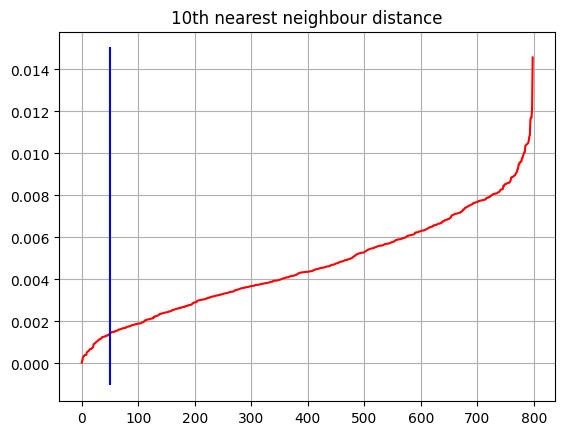

In [669]:
plt.plot(np.arange(0,len(sorted_distances) , 1) , sorted_distances , 'r-')
plt.grid()
plt.title("{}th nearest neighbour distance".format(min_s))
plt.plot([50 for i in range(100)] , np.linspace(-0.001, 0.015, 100) , 'b-')
plt.show()

In [661]:
# we choose epsilon to be 0.0015
clustering = DBSCAN(eps = 0.0015 , min_samples = min_s).fit(embedds_transform)

Text(0.5, 1.0, 'Checking for outliers (Bad Traders) using DBSCAN')

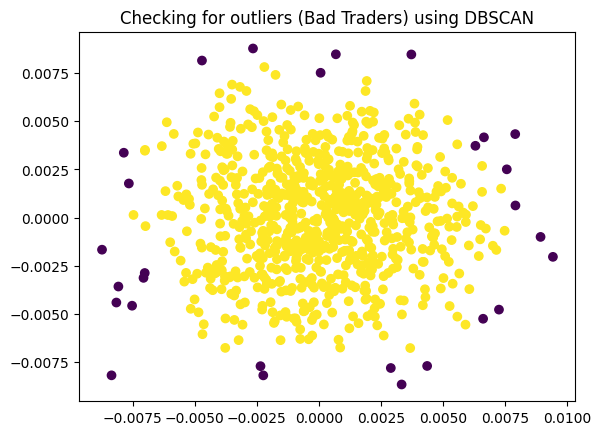

In [662]:
plt.scatter(embedds_transform[:,0] , embedds_transform[:,1] , c=clustering.labels_)
plt.title("Checking for outliers (Bad Traders) using DBSCAN")

In [663]:
# obtaining the bad traders based on our analysis
c = clustering.labels_

bad = []
for idx , i in enumerate(c):
    if i !=0:
        bad.append(points[idx])

In [672]:
print("The bad traders are : ")
for i in bad:
    print(int(i))

The bad traders are : 
1007
1072
1197
1330
1580
1078
1062
1111
1944
1540
2000
1380
1916
1520
1082
2021
1423
1743
1521
1959
1571
1966
1971
2025
2145
1301
1131
1866
